<a href="https://colab.research.google.com/github/Banhkun/CS115/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Import thư viện cần thiết:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Thư viện seaborn dùng cho việc mình họa
import seaborn as sns; sns.set()

In [2]:
#clone github to get data
%cd /content
! rm -rf CS115
! git clone https://github.com/Banhkun/CS115.git
%cd CS115

/content
Cloning into 'CS115'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 42 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (42/42), done.
/content/CS115


## 1.Hard Margin SVM


Tạo một bộ dữ liệu 2 chiều đơn giản để minh họa cho bài toán

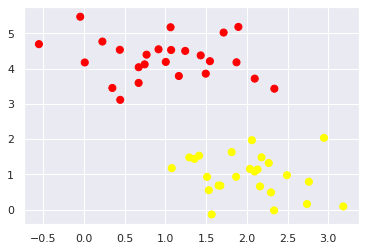

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Ý tưởng của thuật toán SVM là vẽ một đường thẳng để phân chia "ranh giới" giữa 2 phần dữ liệu trên (Hoặc một siêu phẳng trong không gian nhiều chiều hơn).
Nhưng thay vì chỉ đơn giản là vẽ một đường có độ rộng bằng 0 , chúng ta có thể vẽ xung quanh nó một *margin* có độ rộng nào đó, cho đến khi chạm điểm gần nhất.

Trong các máy phân loại SVM, đường tối đa hóa margin này là đường mà chúng ta sẽ chọn làm cho mô hình tối ưu.


In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolor = 'black', facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

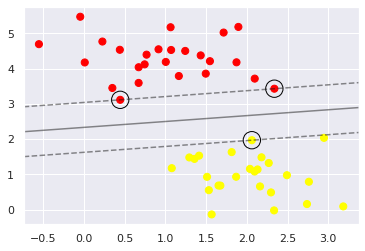

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

Đây là đường phân chia tối đa hóa được margin giữa hai tập hợp điểm.
Ta thấy: một số điểm huấn luyện chỉ chạm vào lề: chúng được bao xung quanh bằng các vòng tròn màu đen trong hình trên.
Những điểm này là yếu tố quan trọng và được gọi là * vectơ hỗ trợ * do đó thuật toán mới có tên gọi là Support Vector Machine.
Trong Scikit-Learn, danh tính của những điểm này được lưu trữ trong thuộc tính `` support_vectors_`` của trình phân loại:

In [8]:
#Trong Scikit-Learn, ta có thể truy xuất các điểm này bằng thuộc tính `` support_vectors_`` của classifier:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Chìa khóa thành công của mô hình này là: chỉ vị trí của các support vector mới được thật sự quan trọng; bất kỳ điểm nào xa hơn so với lề được phân loại đúng sẽ không tác động tới model!


---


Về mặt kỹ thuật, điều này là do những điểm này không đóng góp vào hàm loss được 
sử dụng để fitting model, vì vậy vị trí và số lượng của chúng không quan trọng miễn là chúng không vượt qua biên.

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

Chúng ta có thể thấy sự thay đổi của mô hình khi được học lần lượt từ 10, 60, 120 và 200 điểm

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10,60,120, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 60, 120, 200), value=10), Output()), _dom_classes…

Ở 60 và 120 điểm dữ liệu chúng ta có thể thấy mặc dù số điểm dữ liệu tăng lên gấp đôi nhưng model vẫn không thay đổi. Đó là do model được quyết định bởi các support vector (ở đây là điểm trong không gian 2 chiều).

## 2.Soft Margin SVM

Không phải lúc phải lúc nào cũng có thể phân chia dữ liệu 1 cách hoàn hảo chỉ với 1 đường.

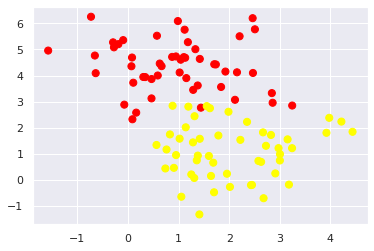

In [11]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Trong trường hợp trên SVM thuần sẽ không hoạt động hiệu quả.
Vì vậy, cần một biến thể của Hard Margin SVM có tên gọi là Soft Margin SVM.
Tức là ta sẽ cho phép hy sinh một số điểm nhiễu và cho chúng chui vào lề nếu điều đó tạo ra được một margin tốt hơn

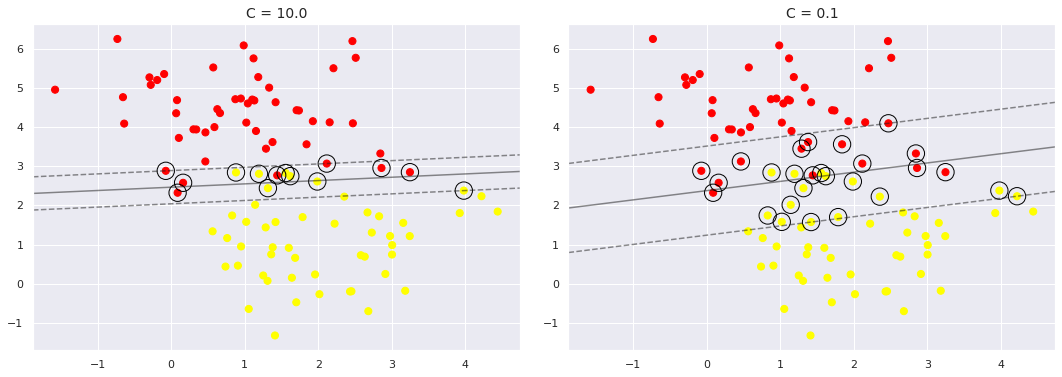

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

Trong SVM độ cứng của lề được kiểm soát bởi một tham số gọi là $ C $.
Tham số này được coi là siêu tham số và được dùng để tune model SVM


###Example: Breast cancer classification


In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [59]:
data_dir = '/content/CS115/data/BCW/data.csv'
df = pd.read_csv(data_dir)  # Dataset - Breast Cancer Wisconsin Data (Ung thư vú Wisconsin)
df.head()  ##Hiển thị 5 hàng đầu


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [60]:
# Label encoding - just simple :>
df['diagnosis'] = df['diagnosis'].map({
    'M': 1, # Label = 1 for Malignant (Ác tính)
    'B': 2  # Label = 2 for Benign (Lành tính)
})
labels = df['diagnosis'].tolist()
df['Class'] = labels  #Thêm một cột class ở cuối
df = df.drop(['id', 'Unnamed: 32', 'diagnosis'],
             axis=1)  #Xóa các cột không cần thiết
target_names = ['', 'M', 'B']
df['attack_type'] = df.Class.apply(lambda x: target_names[x])
df.head()  #Hiển thị 5 hàng đầu

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Class,attack_type
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1,M


In [61]:
X = df.drop(['Class', 'attack_type'], axis='columns')
X.head()
y = df.Class

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(len(X_train))
print(len(X_test))

398
171


In [63]:
# Define 1 lineear SVM classifer
from sklearn.svm import SVC
model = SVC(C = 2.0, kernel='linear')

In [64]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

[2 2 2 1 2 2 1 2 1 1 2 2 2 1 2 2 1 2 2 2 2 2 1 2 2 2 2 2 1 2 1 1 2 2 2 1 2
 2 2 1 2 1 2 2 2 1 2 2 2 2 2 1 2 1 1 1 2 2 2 2 2 1 1 1 2 2 1 2 1 2 1 2 1 1
 1 1 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 1 2 1 1 1 2 2 2 2 2 1 1 2 2 2 2 1 1
 2 2 2 2 2 2 2 2 2 1 2 2 1 2 1 2 2 2 2 2 1 2 2 2 1 1 2 2 1 1 1 2 2 2 1 2 1
 2 2 1 2 1 2 2 2 2 1 2 1 2 1 1 1 1 2 2 2 2 1 2]


In [65]:
# Đánh giá model = f1-score
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.98      0.92      0.95        63
           2       0.96      0.99      0.97       108

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.97      0.96      0.96       171



## 3.Kernel SVM - Beyond linear boundaries

SVM trở nên cực kỳ mạnh mẽ khi nó được kết hợp với * kernels *.

Ở đó, chúng ta chiếu dữ liệu vào không gian có số chiều cao hơn và do đó có thể phù hợp với các mối quan hệ phi tuyến với bộ phân loại tuyến tính.

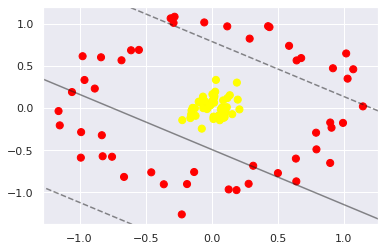

In [66]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Rõ ràng là không có bất kì một đường thẳng hay một sự phân loại tuyến tính nào có thể phân tách dữ liệu này.

Nhưng chúng ta có thể suy nghĩ về cách chúng ta có thể chiếu dữ liệu vào một chiều không gian cao hơn.
Ví dụ: một phép chiếu đơn giản mà chúng tôi có thể sử dụng sẽ là tính toán một **radial basis function** tập trung vào nhóm ở giữa:



In [67]:
r = np.exp(-(X ** 2).sum(1))


Chúng ta có thể hình dung không gian dữ liệu mới này bằng cách sử dụng biểu đồ ba chiều

In [68]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=30, azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(IntSlider(value=30, description='elev', max=90, min=-30), IntSlider(value=30, descriptio…

Có thể thấy rằng khi chiếu qua không gian này, dữ liệu trở nên có thể phân tách tuyến tính một cách đáng kể, bằng cách vẽ một mặt phẳng giữa 2 cụm điểm. Vấn để ở việc ta phải chọn và điều chỉnh cẩn thận phép chiếu làm sao cho thấy đc sự phân tách rõ ràng như vậy.

Một chiến lược cho bài toán này là tính toán một hàm radial basis function tại * mọi * điểm trong tập dữ liệu và để thuật toán SVM sàng lọc kết quả.
Loại biến đổi hàm cơ sở này (basis function transformation) được gọi là * phép biến đổi nhân *, vì nó dựa trên mối quan hệ tương tự (hoặc nhân) giữa mỗi cặp điểm.

Một vấn đề hiến lược này — chiếu $ N $ điểm vào $ N $ không gian — là nó có thể tiêu hao lượng chi phí tính toán khổng lồ khi $ N $ phát triển lớn.
Tuy nhiên, nhờ *thủ thuật hạt nhân* (kernel trick), sự phức tạp đó đã đc giải quyết!


In [69]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)



Trong Scikit-Learn, chúng ta có thể áp dụng Kernel SVM đơn giản bằng cách thay đổi kernel linear của chúng ta thành kernel RBF (Radial Basis Functiono).

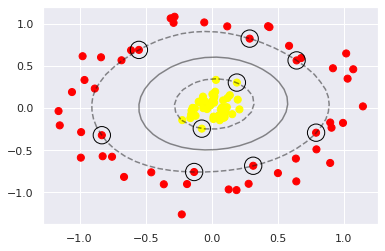

In [70]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');


Sử dụng kernelized SVM này, mô hình có thể phân loại dữ liệu phi tuyến một cách phù hợp.
Chiến lược kernel transformation này thường được sử dụng trong học máy để biến các phương pháp tuyến tính nhanh thành các phương pháp phi tuyến tính nhanh, đặc biệt là đối với các mô hình trong đó *kernel trick* có thể được sử dụng.

### Example: Edible mushroom classification


In [71]:
df=pd.read_csv('/content/CS115/data/mushroom/mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


Toàn bộ dữ liệu đều ở dạng categorical

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

Không có dữ liệu trống


In [73]:
# Encode dữ liệu sang dạng integer
def Encoder(val):
    if val in category:
        return category[val]
    else:
        category[val]=len(category)
    return category[val]
for i in range(df.shape[1]):
    category={}
    df.iloc[:,i]=df.iloc[:,i].apply(Encoder)

In [74]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1
2,1,1,0,2,0,2,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,1,2
3,0,0,1,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,3,1,3,0,1,1,0,1,0,0,0,0,0,0,0,0,1,1,2,1


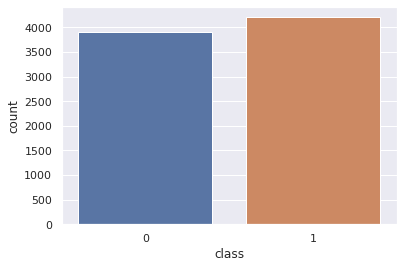

In [75]:
sns.countplot(x='class',data=df)

Bộ dữ liệu khá cân bằng

In [76]:
# Xem xét sự tương quan dữ liệu
correlation=df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(df,annot=True,cmap='coolwarm')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f10871cc5f0> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f10871d40e0> (for post_execute):


KeyboardInterrupt: ignored


Nó mang giá trị 0 trong toàn bộ tập dữ liệu => không đóng góp cho kết quả bài toán

In [79]:
X=df.drop(['class','veil-type'],axis=1) 
y=df['class']
(X_train,X_test,y_train,y_test)=train_test_split(X,y,test_size=0.30)


In [80]:
from sklearn.model_selection import GridSearchCV,train_test_split
# sử dụng kỹ thuật Grid search để tune mô hình với bộ tham số tối ưu nhất
model=SVC()
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 1e-5],'C': [1, 10, 100]},
              {'kernel': ['linear'], 'C': [1, 10, 100]}]
grid=GridSearchCV(model,param_grid,cv=10,scoring='accuracy')
print("Tune hyper-parameters")
grid.fit(X_train,y_train)
print(grid.best_params_)
print(np.round(grid.best_score_,3))

Tune hyper-parameters
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
1.0


In [81]:
#Define lại model sử dụng các siêu tham số ở trên
model=SVC(C=100,gamma=0.001,kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

[1 0 0 ... 0 0 1]


In [82]:
# Đánh giá model = f1-score
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1177
           1       1.00      1.00      1.00      1261

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



Nhận xét: Out trình bộ dữ liệu :>

## 4.Multiclass SVM

Các phương pháp Support Vector Machine đã đề cập (Hard Margin, Soft Margin, Kernel) đều được xây dựng nhằm giải quyết bài toán Binary Classification, tức bài toán phân lớp với chỉ hai classes. Việc này cũng tương tự như Percetron Learning Algorithm hay Logistic Regression vậy. Các mô hình làm việc với bài toán có 2 classes còn được gọi là Binary classifiers. Một cách tự nhiên để mở rộng các mô hình này áp dụng cho các bài toán multi-class classification, tức có nhiều classes dữ liệu khác nhau, là sử dụng nhiều binary classifiers và các kỹ thuật như one-vs-one hoặc one-vs-rest. Cách làm này có những hạn chế như đã trình bày trong bài Softmax Regression.

### Example: Face Recognition

Đến với tác vụ nâng cao hơn trong bài toán thực tế.
Ta sẽ sử dụng các dữ liệu Labeled Faces in the Wild dataset, bao gồm hàng nghìn bức ảnh đối chiếu của các nhân vật công chúng khác nhau.


In [84]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Tổng cộng 1348 ảnh (62x47)

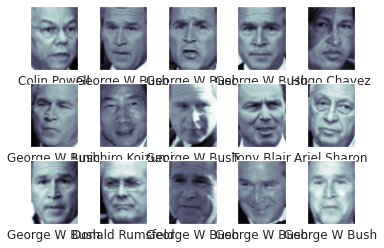

In [85]:
#Minh họa một vài khuôn mặt 
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Mỗi hình ảnh chứa [62 × 47] hoặc gần 3.000 pixel.
Ở đây, chúng ta sẽ sử dụng một phương pháp rút trích đặc trưng huyền thoại PCA (Principal-Component-Analysis) để trích xuất 150 thành phần cơ bản để đưa vào máy phân loại SVM. Có thể thay thế bằng mạng CNN hiện đại.
Chúng ta có thể làm điều này một cách đơn giản nhất bằng cách đóng gói bộ tiền xử lý và bộ phân loại vào một pipeline duy nhất:

In [115]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [116]:
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target,test_size=0.20, random_state=42)


Cuối cùng, 1 lần nữa sử dụng grid search cross-validation để tune các tham số.

In [122]:
param_grid = {'svc__C': [1, 5, 10, 50, 100],
              'svc__gamma': [1e-3, 5e-3, 1e-4, 5e-4, 1e-5]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(X_train, y_train)
print(grid.best_params_)

CPU times: user 1min 36s, sys: 1min 1s, total: 2min 38s
Wall time: 1min 34s
{'svc__C': 5, 'svc__gamma': 0.005}


In [111]:
# model=SVC()
# param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 5e-3, 1e-4, 5e-4, 1e-5],'C': [1, 5, 10, 50, 100]},
#               {'kernel': ['linear'], 'C': [1, 10, 100]}]
# grid=GridSearchCV(model,param_grid,cv=10,scoring='accuracy')
# print("Tune hyper-parameters")
# grid.fit(X_train,y_train)
# print(grid.best_params_)
# print(np.round(grid.best_score_,3))

Tune hyper-parameters
{'C': 1, 'kernel': 'linear'}
0.844


In [123]:
# Sử dụng các siêu tham số trên để xây dựng mô hình
model = grid.best_estimator_
y_pred = model.predict(X_test)

Minh họa một số dự đoán của model

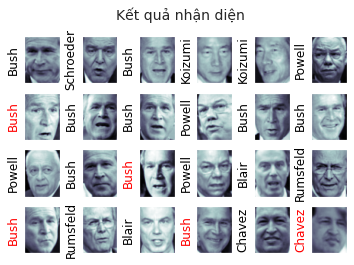

In [124]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_pred[i]].split()[-1],
                   color='black' if yfit[i] == y_test[i] else 'red') # Các dự đoán lỗi đc tô màu đỏ
fig.suptitle('Kết quả nhận diện', size=14);

In [125]:
# Đánh giá = f1-score
print(classification_report(y_test, y_pred,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.58      0.70        12
     Colin Powell       0.86      0.84      0.85        51
  Donald Rumsfeld       0.91      0.84      0.87        25
    George W Bush       0.80      0.96      0.87        98
Gerhard Schroeder       1.00      0.76      0.86        21
      Hugo Chavez       1.00      0.67      0.80        15
Junichiro Koizumi       1.00      0.70      0.82        10
       Tony Blair       0.89      0.89      0.89        38

         accuracy                           0.86       270
        macro avg       0.92      0.78      0.83       270
     weighted avg       0.87      0.86      0.86       270



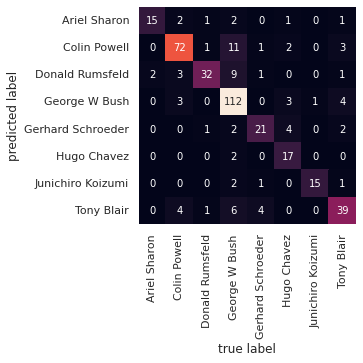

In [126]:
# Confusion_matrix
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');